# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap

Load feature names.

In [1]:
feature_names = []
with open('Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

with open('Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

Total variance explained at k= 1: 0.1640, additional variance explained: 0.1640
Total variance explained at k= 2: 0.2973, additional variance explained: 0.1332
Total variance explained at k= 3: 0.3990, additional variance explained: 0.1017
Total variance explained at k= 4: 0.4696, additional variance explained: 0.0706
Total variance explained at k= 5: 0.5083, additional variance explained: 0.0387
Total variance explained at k= 6: 0.5451, additional variance explained: 0.0368
Total variance explained at k= 7: 0.5764, additional variance explained: 0.0313
Total variance explained at k= 8: 0.6037, additional variance explained: 0.0273
Total variance explained at k= 9: 0.6299, additional variance explained: 0.0262
Total variance explained at k=10: 0.6522, additional variance explained: 0.0223
Total variance explained at k=11: 0.6727, additional variance explained: 0.0205
Total variance explained at k=12: 0.6914, additional variance explained: 0.0187
Total variance explained at k=13: 0.7087

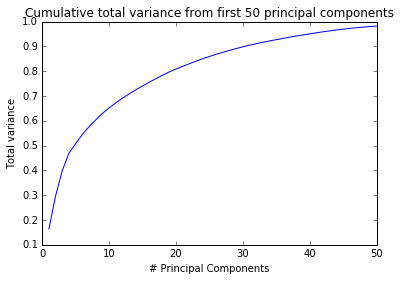

In [57]:
def P1():
### STUDENT START ###    
    n=50
    pca = PCA(n_components=n)
    pca.fit(train_data)
    cum_sums = []
    for i in range(1, n+1):
        cum_sum = np.sum(pca.explained_variance_ratio_[:i])
        cum_sums.append(cum_sum)
        print "Total variance explained at k={0:2d}: {1:.4f}, " \
              "additional variance explained: {2:.4f}".format(
                i, cum_sum, pca.explained_variance_ratio_[i-1])
    
    # Plot cumulative variance.
    plt.plot(range(1, n+1), cum_sums)
    plt.title("Cumulative total variance from first 50 principal components")
    plt.xlabel('# Principal Components')
    plt.ylabel('Total variance')

### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

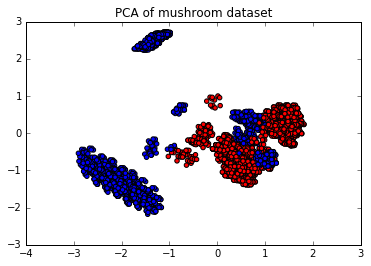

In [60]:
def P2():
### STUDENT START ###
    # Project training data to 2 dimensions.
    pca = PCA(n_components=2)
    projected_train_data = pca.fit_transform(train_data)
    
    # Plot data.
    plt.clf()
    colormap = np.array(['r', 'b'])
    plt.scatter(projected_train_data[:, 0], projected_train_data[:, 1], c=colormap[train_labels])
    plt.title("PCA of mushroom dataset")

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

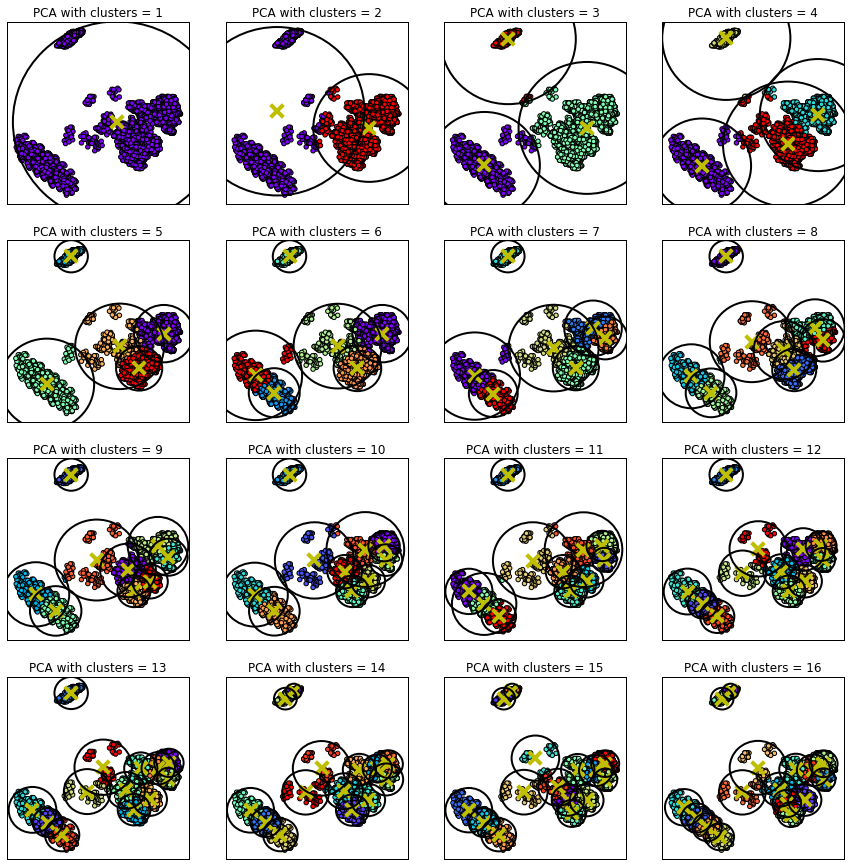

In [123]:
def P3():
### STUDENT START ###
    # Project training data to 2 dimensions.
    pca = PCA(n_components=2)
    projected_train_data = pca.fit_transform(train_data)

    plt.figure(figsize=(15, 15))
    for i in range(1,17):
        # Run KMeans with 16 clusters over 2d projected data.
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(projected_train_data)

        # Plot data.
        p = plt.subplot(4, 4, i)
        plt.title("PCA with clusters = {0}".format(i))
        label_colors = kmeans.labels_.astype(np.float)
        p.scatter(projected_train_data[:, 0], projected_train_data[:, 1],
                  marker='o', c=label_colors, cmap='rainbow')
        plt.setp(p, xticks=(), yticks=())

        # Plot centroids in yellow x.
        centroids = kmeans.cluster_centers_
        p.scatter(centroids[:, 0], centroids[:, 1], c='y', marker='x',
                  linewidth=4, s=160)

        # Plot circle (in black) through most distant point assigned to each cluster.
        # Compute distances.
        distances = kmeans.transform(projected_train_data)
        #fig = plt.gcf()
        for k in range(i):
            # Find max distance to use as radius of circle.
            max_dist = np.max(distances[kmeans.labels_ == k, k])
            # Plot circle around centroid.
            circle = plt.Circle(centroids[k], radius=max_dist, color='k', fill=False, lw=2)
            p.add_artist(circle)

### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

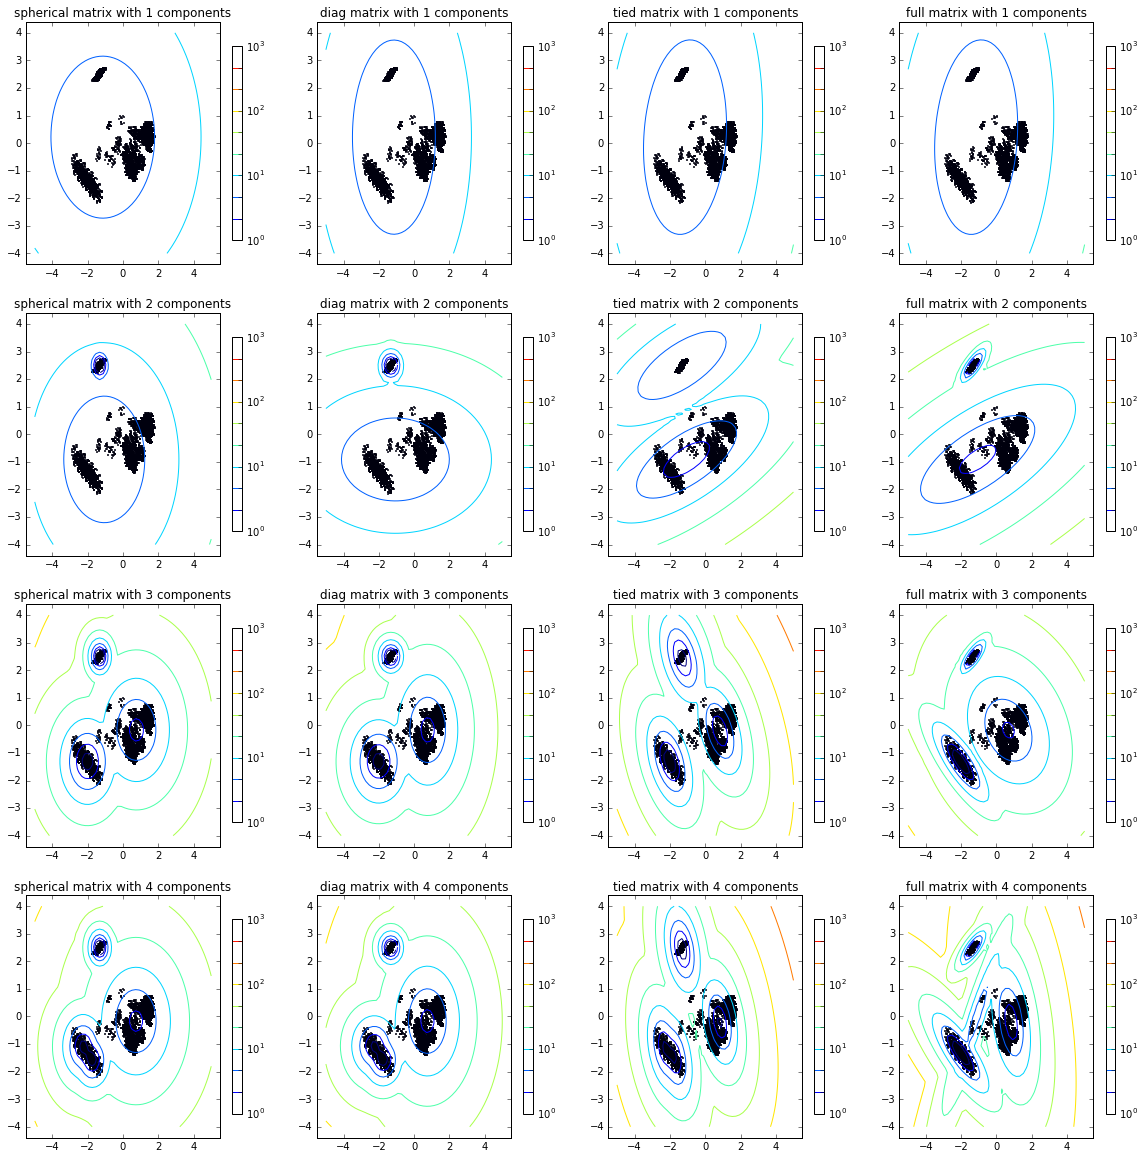

In [58]:
def P4():
### STUDENT START ###
    # Project training data to 2 dimensions.
    pca = PCA(n_components=2)
    projected_train_data = pca.fit_transform(train_data)
    
    # Fit a Gaussian Mixture Model and plot estimated density curves.
    covariance_types = ["spherical", "diag", "tied", "full"]
    plt.figure(figsize=(20, 20))
    for n in range(1,5):
        for i, covar_type in enumerate(covariance_types):
            gmm = GMM(n_components=n, covariance_type=covar_type)
            gmm.fit(projected_train_data[train_labels == 1,:])

            # Display predicted scores by the model as a contour plot.
            x = np.linspace(-5.0, 5.0)
            y = np.linspace(-4.0, 4.0)
            X_grid, Y_grid = np.meshgrid(x, y)
            XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
            Z = -gmm.score_samples(XX)[0]
            Z = Z.reshape(X_grid.shape)

            ax = plt.subplot(4, 4, (4*(n-1)) + i + 1)
            plt.title("{0} matrix with {1} components".format(covar_type, n))
            CS = plt.contour(X_grid, Y_grid, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(projected_train_data[:, 0], projected_train_data[:, 1], .8)

### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [75]:
def P5():
### STUDENT START ###
    # Project training and test data to 2 dimensions.
    pca = PCA(n_components=2)
    projected_train_data = pca.fit_transform(train_data)
    projected_test_data = pca.transform(test_data)
    
    # Fit 4-component full covariance GMM for positive examples.
    gmm_pos = GMM(n_components=4, covariance_type="full")
    gmm_pos.fit(projected_train_data[train_labels == 1,:])
    pos_scores = gmm_pos.score(projected_test_data)
    
    # Fit 4-component full covariance GMM for negative examples.
    gmm_neg = GMM(n_components=4, covariance_type="full")
    gmm_neg.fit(projected_train_data[train_labels == 0,:])
    neg_scores = gmm_neg.score(projected_test_data)
    
    # Combine scores from GMMs into one array.
    gmm_scores = np.column_stack((neg_scores, pos_scores))
    
    # Predict labels based off of which GMM gave larger prob.
    predictions = np.argmax(gmm_scores, axis=1)
    
    # Compute accuracy = (total - num_incorrect) / total.
    num_incorrect = np.sum(abs(predictions - test_labels))
    print "Num incorrect: {0}".format(num_incorrect)
    accuracy = float(predictions.shape[0] - num_incorrect) / predictions.shape[0]
    print "Accuracy: {0}".format(accuracy)

### STUDENT END ###

P5()

Num incorrect: 55
Accuracy: 0.951067615658


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [40]:
def ComputeGMMAccuracy(pca_components, gmm_components, covar_type):
    # Project training and test data to pca_components dimensions.
    pca = PCA(n_components=pca_components)
    projected_train_data = pca.fit_transform(train_data)
    projected_test_data = pca.transform(test_data)
    
    # Fit GMM for positive examples.
    gmm_pos = GMM(n_components=gmm_components, covariance_type=covar_type)
    gmm_pos.fit(projected_train_data[train_labels == 1,:])
    pos_scores = gmm_pos.score(projected_test_data)

    # Fit GMM for negative examples.
    gmm_neg = GMM(n_components=gmm_components, covariance_type=covar_type)
    gmm_neg.fit(projected_train_data[train_labels == 0,:])
    neg_scores = gmm_neg.score(projected_test_data)

    # Combine scores from GMMs into one array.
    gmm_scores = np.column_stack((neg_scores, pos_scores))

    # Predict labels based off of which GMM gave larger prob.
    predictions = np.argmax(gmm_scores, axis=1)

    # Compute accuracy = (total - num_incorrect) / total.
    num_incorrect = np.sum(abs(predictions - test_labels))
    accuracy = float(predictions.shape[0] - num_incorrect) / predictions.shape[0]
    return accuracy

def n_parameters(pca_components, gmm_components, covar_type):
        """Return the number of free parameters in the model."""
        ndim = pca_components
        if covar_type == 'full':
            cov_params = gmm_components * ndim * (ndim + 1) / 2.
        elif covar_type == 'diag':
            cov_params = gmm_components * ndim
        elif covar_type == 'tied':
            cov_params = ndim * (ndim + 1) / 2.
        elif covar_type == 'spherical':
            cov_params = gmm_components
        mean_params = ndim * gmm_components
        return int(cov_params + mean_params + gmm_components - 1)*2

def P6():
### STUDENT START ###
    covariance_types = ["spherical", "diag", "tied", "full"]
    accuracies = []
    print "------------------------------------------------------------------------------------------"
    print "{0:<20s}{1:<20s}{2:<20s}{3:<20s}{4:<20s}".format(
            "PCA Components", "GMM Components", "Covariance Type", "# Params", "Accuracy")
    print "------------------------------------------------------------------------------------------"
    for pca_components in range(1,6):
        for gmm_components in range(1,6):
            for covar_type in covariance_types:
                num_parameters = n_parameters(pca_components, gmm_components, covar_type)
                if num_parameters > 50:
                    continue
                accuracy = ComputeGMMAccuracy(pca_components, gmm_components, covar_type)
                accuracies.append(accuracy)
                print "{0:<20}{1:<20}{2:<20}{3:<20}{4:<.5f}".format(
                    pca_components, gmm_components, covar_type, num_parameters, accuracy)
    
    print "\n"
    print "------------------------------Best Combination--------------------------------------------"
    print "PCA Comps: 4, GMM Comps: 3, Covariance Type: tied, # Params: 48"
    print "Accuracy: {0:.5f}".format(max(accuracies))
    print "------------------------------------------------------------------------------------------"

### STUDENT END ###

P6()

------------------------------------------------------------------------------------------
PCA Components      GMM Components      Covariance Type     # Params            Accuracy            
------------------------------------------------------------------------------------------
1                   1                   spherical           4                   0.84431
1                   1                   diag                4                   0.84431
1                   1                   tied                4                   0.84431
1                   1                   full                4                   0.84431
1                   2                   spherical           10                  0.89947
1                   2                   diag                10                  0.89947
1                   2                   tied                8                   0.88434
1                   2                   full                10                  0.89947
1            